# Iskanje besed, specifičnih za dokumente z uporabo transformacije TF-IDF

Tokrat bomo poskusili specifične besede v dokumentu določiti z uporabo transformacije TF-IDF, ki uteži besede glede na njihovo pogostost v besedilu. Besede, ki močno zaznamujejo manjšo množico dokumentov, bodo tako imele večjo težo kot take, ki so vseprisotne v korpusu.

Iz seznama predlogov vladi izberemo zadnjih 100 dokumentov, jih predobledamo na enak način kot v prejšnjih primerih in za vsak dokument izračunamo najbolj specifične besede. Uporabili bomo utežitev TF-IDF in poiskali nekaj najvišje uteženih besed v množici.

In [1]:
from textsemantics.server_api import ServerAPI
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords', quiet=True)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]

tokens_list = preprocess(texts)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

joined_texts = [' '.join(tokens) for tokens in tokens_list]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(joined_texts)
feature_names = vectorizer.get_feature_names()

In [3]:
def find_tfidf_words(document_id, n_words=5):
    n_words = n_words if n_words and n_words <= len(feature_names) else len(feature_names)
    feature_index = X[document_id,:].nonzero()[1]
    features = [(feature_names[i], X[document_id, i]) for i in feature_index]
    return sorted(features, key=lambda tup: tup[1], reverse=True)[:n_words]

Nato izberemo, koliko najvišje rangiranih besed nas zanima, ter kateri dokument bomo opazovali. Izbrali smo najbolj zanimivih pet be

In [4]:
num_of_words = 5

In [5]:
from IPython.display import display, Markdown

def display_document_and_specific_words(doc_ind): 
    top_words = find_tfidf_words(doc_ind, n_words=num_of_words)
    s = f"## {metadata.iloc[doc_ind]['title']}\n {texts[doc_ind]}\n"
    s += f"\n### {num_of_words} najvišje uteženih besed z metodo TF-IDF:\n"
    s += "|Beseda|Utež|\n"
    s += "|---|---|\n"
    for word, value in top_words:
        s += f'|{word:<15}|{value:.2f}|\n'

    display(Markdown(s))

Poglejmo dva dokumenta in 5 najbolj specifičnih besed, ki jih najde utežitev TF-IDF.

In [6]:
display_document_and_specific_words(4)

## Sprememba stopnje DDV za stanovanjske nepremičnine
 Trenutna obdavčitev je 9,5% za stanovanja do 120m2 in hiše do 250m2. Če površina presega cenzus, se na celotno ceno obračuna DDV po stopnji 22%. Posledično je stanovanje površine 121m2 več kot dvakrat bolj obdavčeno, kot stanovanje površine 119m2, kar je absurdno.
Predlagam, da se obdavčitev spremeni tako, da je površina do 120m2 stanovanja oz. 250m2 hiše vedno obdavčena po 9,5%. Površina, ki presega cenzus, pa naj bo višje obdavčena.

### 5 najvišje uteženih besed z metodo TF-IDF:
|Beseda|Utež|
|---|---|
|površina       |0.56|
|stanovanje     |0.39|
|obdavčen       |0.34|
|cenzus         |0.22|
|250m2          |0.22|


In [7]:
display_document_and_specific_words(13)

## Videvanja z partnerjem z tujine med epidemijo.
 Predlagam, da se kot izjema za prehajanje regije, občine ali državne meje, uvede tudi vzdrževanje stikov z partnerji iz tujine. Sam, kot tudi drugi smo namreč zaradi tega prizadeti, saj nas veliko živi ob meji s Hrvaško na primer, 15 min vožnje stran eden od drugega, a zaradi restriktivnih srečanje ni možno, čez Kolpo si pa lahko mahamo. Je bil 1. Val dovolj, da se nisem mogel videti s punco, katere tudi skoraj nisem prepoznal, po 2 mesecih razdvojenosti. Lp

### 5 najvišje uteženih besed z metodo TF-IDF:
|Beseda|Utež|
|---|---|
|meja           |0.32|
|razdvojenost   |0.20|
|punca          |0.20|
|mahati         |0.20|
|kolpa          |0.20|


## Dendrogram z specifičnimi besedami

Sedaj, ko imamo postopek za računanje specifičnih besed, lahko te prikažemo v dendrogramu, ki prikazuje podobnosti med dokumenti. Ker bi bil dendrogram z vsemi dokumenti preobsežen, se odločimo za dokuemnte, ki smo jih že obravnavali v zvezku `03_02_distances_and_similarities`.

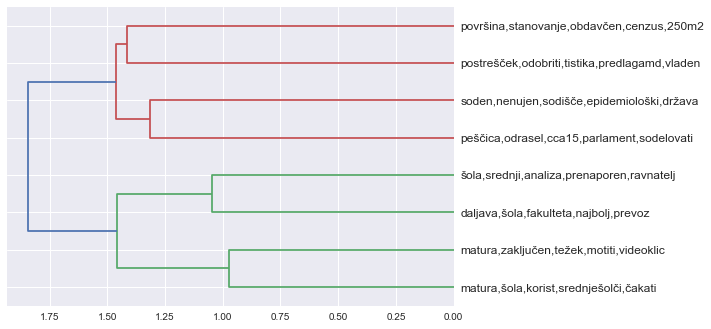

In [8]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

idx = [7, 18, 20, 30, 1, 2, 3, 4]

# dendrogram
plt.style.use('seaborn')
tfidf = X[idx, :]
dist_mat = 1 - cosine_similarity(tfidf)
linkage = ward(dist_mat)

# specific words
spec_words = [",".join(w for w, _ in find_tfidf_words(i, n_words=num_of_words)) for i in idx]
dendrogram(
    linkage, color_threshold=1.6, 
    labels=spec_words,
    orientation="left"
);